## Load and visualize texutres

In [2]:
%pip install matplotlib opencv-python

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: matplotlib in c:\users\amine\appdata\local\programs\python\python310\lib\site-packages (3.10.6)
  Using cached opencv_python-4.12.0.88-cp37-abi3-win_amd64.whl (39.0 MB)




[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Text(0.5, 1.0, 'Stone Texture')

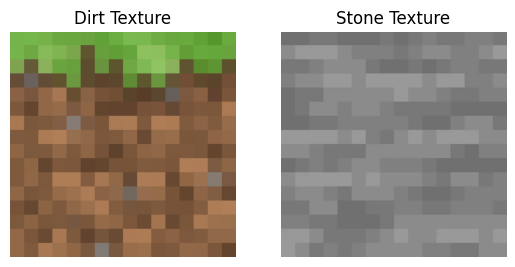

In [60]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

dirt_texture: np.array = cv.imread("assets/dirt.png")
stone_texture: np.array = cv.imread("assets/stone.png")

dirt_texture = cv.cvtColor(dirt_texture, cv.COLOR_BGR2RGB)
stone_texture = cv.cvtColor(stone_texture, cv.COLOR_BGR2RGB)

plt.subplot(1, 2, 1) 
plt.imshow(dirt_texture)  
plt.axis('off')  
plt.title("Dirt Texture") 

plt.subplot(1, 2, 2) 
plt.imshow(stone_texture)  
plt.axis('off')  
plt.title("Stone Texture") 

## Turn the textures into pointclouds

In [61]:
dirt_texture.shape

(1024, 1024, 3)

In [62]:
def texture_to_pointcloud(tex: np.ndarray) -> np.array:
    h, w, _ = tex.shape

    xs, ys = np.meshgrid(np.arange(w), np.arange(h))

    xs = xs.reshape(-1)
    ys = ys.reshape(-1)
    colors = tex.reshape(-1, 3)

    pointcloud = np.column_stack((xs, ys, colors))

    return pointcloud


dirt_pointcloud: np.array = texture_to_pointcloud(dirt_texture).astype(np.float64)
stone_pointcloud: np.array = texture_to_pointcloud(stone_texture).astype(np.float64)

In [63]:
def pointcloud_to_texture(pointcloud: np.ndarray, shape: tuple) -> np.ndarray:
    img = np.zeros(shape, dtype=np.uint8)

    xs = np.clip(pointcloud[:, 0].round().astype(int), 0, shape[1]-1)
    ys = np.clip(pointcloud[:, 1].round().astype(int), 0, shape[0]-1)
    colors = np.clip(pointcloud[:, 2:], 0, 255).astype(np.uint8)

    img[ys, xs] = colors
    return img

In [64]:
dirt_pointcloud.shape

(1048576, 5)

## Sliced Quadratic Wasserstein Distance

In [65]:
def sliced_wasserstein_2(X: np.array, Y: np.array, K: int = 64) -> float:
    _, d = X.shape
    accum: float = 0
    
    for _ in range(K):
        v: np.array = np.random.normal(0, 1, d) # d refers to the dimension of elements in our pointclouds (x, y, r, g, b)

        theta: np.array = np.zeros_like(v)
        if np.linalg.norm(v) != 0 : theta = v / np.linalg.norm(v)  

        X_proj: np.array = X.dot(theta)
        Y_proj: np.array = Y.dot(theta)

        X_proj, Y_proj = np.sort(X_proj), np.sort(Y_proj)

        w_2 = np.mean((X_proj - Y_proj)**2)

        accum += w_2
    
    return accum / K

In [66]:
# This should yeild 1.0 since the distributions have uniform spacing
X = np.array([[0], [0.5], [1]])
Y = np.array([[1], [1.5], [2]])

dist = sliced_wasserstein_2(X, Y, 10)
print(dist)  # should be 1

1.0


## Sliced Quadratic Wasserstein Barycenter

In [67]:
def sliced_wasserstein_2_barycenter(Y: np.ndarray, omega_size: int = 10, step_size: float = 0.01, n_iter: int = 100) -> np.ndarray:
    n, d = Y.shape
    
    # Initialize barycenter with a random sample from Y as suggested by the paper
    idx = np.random.randint(0, n)
    X = Y[idx:idx+1].copy()
    X = np.tile(X, (n, 1))

    for _ in range(n_iter):
        gradient = np.zeros_like(X)

        for _ in range(omega_size):
            v = np.random.normal(0, 1, d)
            if np.linalg.norm(v) == 0:
                continue
            theta = v / np.linalg.norm(v)

            X_proj = X.dot(theta)
            Y_proj = np.sort(Y.dot(theta))

            diff = X_proj - Y_proj

            gradient += np.outer(diff, theta)

        gradient /= omega_size

        X -= step_size * gradient

    return X

## First Order Statistical Mixing

In [68]:
def extract_atoms(tex, patch_size=8):
    h, w, _= tex.shape
    atoms = []
    
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            patch = tex[i:i+patch_size, j:j+patch_size]
            if patch.shape[0] != patch_size or patch.shape[1] != patch_size:
                continue  # skip incomplete patch at edges
            atoms.append(patch.reshape(-1, 3))
    return atoms 

def reconstruct_from_atoms(atoms, tex_shape, patch_size=8):
    h, w, _ = tex_shape
    img = np.zeros(tex_shape, dtype=np.uint8)
    idx = 0
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            if idx >= len(atoms):
                break
            patch = atoms[idx].reshape(patch_size, patch_size, 3)
            img[i:i+patch_size, j:j+patch_size] = np.clip(patch, 0, 255).astype(np.uint8)
            idx += 1
    return img

In [72]:
def first_order_texture_mix(tex_1, tex_2, rho=0.5, patch_size=8, n_iter=20):
    atoms_1 = extract_atoms(tex_1, patch_size)
    atoms_2 = extract_atoms(tex_2, patch_size)
    assert len(atoms_1) == len(atoms_2), "Textures must have same number of atoms"

    mixed_atoms = []
    for a_1, a_2 in zip(atoms_1, atoms_2):
        n_points = a_1.shape[0]
        n_1 = int(n_points * rho)
        n_2 = n_points - n_1
        X_init = np.vstack([a_1[np.random.choice(n_points, n_1, replace=True)],
                            a_2[np.random.choice(n_points, n_points, replace=True)][:n_2]])
        
        bc = sliced_wasserstein_2_barycenter(X_init, omega_size=5, step_size=0.01, n_iter=n_iter)
        mixed_atoms.append(bc)

    
    mixed_tex = reconstruct_from_atoms(mixed_atoms, tex_1.shape, patch_size)
    return mixed_tex

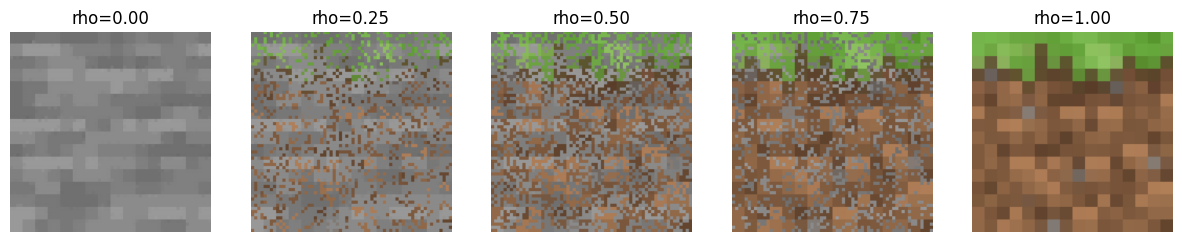

In [ ]:
rhos = [0.0, 0.25, 0.5, 0.75, 1.0] 
fig, axes = plt.subplots(1, len(rhos), figsize=(15,5))

for ax, rho in zip(axes, rhos):
    mixed = first_order_texture_mix(dirt_texture.astype(np.float64), stone_texture.astype(np.float64), rho=rho, patch_size=16, n_iter=10)
    ax.imshow(mixed)
    ax.axis('off')
    ax.set_title(f"rho={rho:.2f}")

## Higher-order statistical mixing

In [ ]:
def extract_joint_blocks(tex, block_size=4):
    h, w, _ = tex.shape
    blocks = []
    for i in range(0, h - block_size + 1, block_size):
        for j in range(0, w - block_size + 1, block_size):
            block = tex[i:i+block_size, j:j+block_size].reshape(-1, 3)
            blocks.append(block)
    return blocks

def reconstruct_from_joint_blocks(blocks, tex_shape, block_size=4):
    h, w, c = tex_shape
    img = np.zeros(tex_shape, dtype=np.float64)
    count = np.zeros((h, w, 1), dtype=np.float64)
    
    idx = 0
    for i in range(0, h - block_size + 1, block_size):
        for j in range(0, w - block_size + 1, block_size):
            block = blocks[idx].reshape(block_size, block_size, 3)
            img[i:i+block_size, j:j+block_size] += block
            count[i:i+block_size, j:j+block_size] += 1
            idx += 1
    
    img /= count
    return np.clip(img, 0, 255).astype(np.uint8)

In [75]:
def compute_higher_order_barycenter(blocks_list, rhos, omega_size=5, step_size=0.01, n_iter=20):
    num_blocks = len(blocks_list[0])
    mixed_blocks = []

    for idx in range(num_blocks):
        blocks = [blocks_list[j][idx] for j in range(len(blocks_list))]
        n_points = blocks[0].shape[0]
        X_init = np.vstack([
            b[np.random.choice(n_points, int(n_points * rho), replace=True)]
            for b, rho in zip(blocks, rhos)
        ])
        bc = sliced_wasserstein_2_barycenter(X_init, omega_size=omega_size, step_size=step_size, n_iter=n_iter)
        mixed_blocks.append(bc)
    return mixed_blocks


In [76]:
def higher_order_texture_mix(textures, rhos, block_size=4, n_iter=20):
    blocks_list = [extract_joint_blocks(tex, block_size) for tex in textures]

    mixed_blocks = compute_higher_order_barycenter(blocks_list, rhos, n_iter=n_iter)

    tex_shape = textures[0].shape
    mixed_tex = reconstruct_from_joint_blocks(mixed_blocks, tex_shape, block_size)
    return mixed_tex

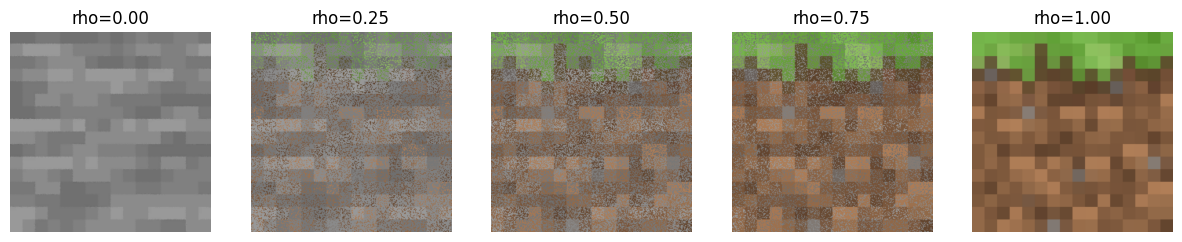

In [77]:
rhos = [0.0, 0.25, 0.5, 0.75, 1.0]

fig, axes = plt.subplots(1, len(rhos), figsize=(15,5))

for ax, rho in zip(axes, rhos):
    mixed = higher_order_texture_mix([dirt_texture.astype(np.float64), stone_texture.astype(np.float64)], [rho, 1-rho], block_size=4, n_iter=10)
    ax.imshow(mixed.astype(np.uint8))
    ax.axis('off')
    ax.set_title(f"rho={rho:.2f}")

plt.show()